In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords 
from collections import Counter
import os

C:\Users\Ming Xuan\AppData\Local\Temp\ipykernel_8980\2238641776.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_data(files):

    data_path = os.getcwd()+'/Data/'
    combined_df = pd.DataFrame(columns=['text', 'label'])
    df_columns = ['text', 'label']
    
    for x in files:

        df = pd.read_csv(data_path+x)
        df = df[df.columns[:2]]
        df.columns = df_columns
        df['text'] = df['text'].astype(str)

        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

In [3]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
files = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv', 'dataset4.csv']#, 'dataset5.csv']

data_df = get_data(files)
data_df

C:\Users\Ming Xuan\AppData\Local\Temp\ipykernel_8980\622898227.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, df], ignore_index=True)


,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0
...,...,...
32511,"""Nothing beats the feeling of achieving someth...",0.0
32512,Too much homework Feeling Stressed!,1.0
32513,"overworked in school,, causes me headache",1.0
32514,How come my friends immediately get to know st...,0.0


In [5]:
data_df['label'].value_counts()

label
0.0    24406
1.0     8105
Name: count, dtype: int64

In [6]:
def even_out_dataframe(df):

    counts = df['label'].value_counts()

    if counts[0] > counts[1]:
        desired_count = counts[1]
        label = 0
        non_label = 1
    else:
        desired_count = counts[0]
        label = 1
        non_label = 0

    df_balanced = pd.concat([df[df['label'] == label].sample(desired_count), df[df['label'] == non_label]], ignore_index=True)
    
    return df_balanced

In [7]:
balanced_df = even_out_dataframe(data_df)
print(balanced_df['label'].value_counts())

data_df = balanced_df

label
0.0    8105
1.0    8105
Name: count, dtype: int64


In [8]:
X, y = data_df['text'].values, data_df['label'].values

test_size = 0.2

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size= test_size)

print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (12968,)
shape of test data is (3242,)


In [9]:
from utils.common_functions import tockenize, padding_, preprocess_string

DICT_LENGTH = 100000
MAX_STR_LENGTH = 64

x_train,x_test,vocab = tockenize(x_train,x_test, DICT_LENGTH)
print(f'Length of vocabulary is {len(vocab)}')

x_train_pad = padding_(x_train,MAX_STR_LENGTH)
x_test_pad = padding_(x_test,MAX_STR_LENGTH)

12968
Length of vocabulary is 25859


In [10]:
x_train_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,  5593,   625,
        3385,   196,   270, 10384,  5594,    51,    29,  3734,     2,
        1048])

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [12]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter._dataset[0]

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([64])
Sample input: 
 tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  5593,   625,  3385,   196,   270, 10384,  5594,    51,
           29,  3734,     2,  1048], dtype=torch.int32)
Sample input: 
 tensor(1., dtype=torch.float64)


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

def f1_score_func(preds, labels):
    # Takes in 2 tensors

    preds, labels = preds.cpu().detach().numpy(), labels.cpu().detach().numpy()

    f1 = f1_score(labels, preds, average = 'weighted')
    p_score = precision_score(labels, preds)
    r_score = recall_score(labels, preds)
    return f1, p_score, r_score

In [37]:
def train_loop(train_loader, model, loss_fn, optimizer, device):
    model.train()

    size = len(train_loader.dataset)
    num_batches = len(train_loader)

    train_loss, train_correct = 0, 0

    for word_embed, labels in train_loader:
        # Transfering images and labels to GPU if available
        word_embed, labels = word_embed.to(device), labels.to(device)
        
        # Forward pass 
        outputs = model(word_embed)
        outputs = outputs.type(torch.float64)

        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predicted = torch.round(outputs)
        
        train_correct += (predicted == labels).type(torch.float).sum().item()

    f1, p_score, r_score = f1_score_func(predicted, labels)
    train_loss /= num_batches
    train_correct /=size
    
    return train_loss, train_correct, f1, p_score, r_score

def test_loop(test_loader, model, loss_fn, device):
    model.eval()

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, test_correct = 0, 0

    predicted_list, labels_list = [], []

    with torch.no_grad():
        for word_embed, labels in test_loader:

            word_embed, labels = word_embed.to(device), labels.to(device)

            outputs = model(word_embed)
            outputs = outputs.type(torch.float64)

            test_loss += loss_fn(outputs, labels).item()

            predicted = torch.round(outputs)
            test_correct += (predicted == labels).type(torch.float).sum().item()

            predicted_list.extend(predicted.cpu())
            labels_list.extend(labels.cpu())

    f1, p_score, r_score = f1_score_func(predicted, labels)
    test_loss /= num_batches
    test_correct /= size
    
    return test_loss, test_correct, f1, p_score, r_score, predicted_list, labels_list



In [38]:
from utils.models import SentimentRNN
from utils.early_stopper import EarlyStopper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
hidden_dim = 256
patience = 3

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim)
early_stopper = EarlyStopper(patience=patience, min_delta=0)

#moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(25860, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_extra): Linear(in_features=256, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [39]:
#from Utils.common_functions import train_loop, test_loop

# loss and optimization functions
lr=0.001

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_acc = 0

epochs = 50
# train for some number of epochs
tr_acc, te_acc = [], []
tr_loss, te_loss = [], []

for epoch in range(epochs):

    train_loss, train_correct, train_f1, train_p_score, train_r_score = train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loss, test_correct, test_f1, test_p_score, test_r_score, predicted, labels = test_loop(test_loader, model, loss_fn, device)

    print('Train Acc epoch {} : Acc {} , F1 {} , Precision {} , Recall {} '.format(epoch, train_correct, train_f1, train_p_score, train_r_score))
    print('Test Acc epoch {} : Acc {} , F1 {} , Precision {} , Recall {}'.format(epoch, test_correct, test_f1, test_p_score, test_r_score))

    tr_acc.append(train_correct)
    te_acc.append(test_correct)

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    if test_correct > best_acc:
        best_acc = test_correct
        store_predicted, store_labels = predicted, labels

    if early_stopper.early_stop(test_loss):
        print("Done! Early stopped at {}".format(epoch+1))
        break

Train Acc epoch 0 : Acc 0.8239512646514497 , F1 0.8787030941408822 , Precision 0.7222222222222222 , Recall 1.0 
Test Acc epoch 0 : Acc 0.905305367057372 , F1 1.0 , Precision 1.0 , Recall 1.0
Train Acc epoch 1 : Acc 0.9158698334361505 , F1 1.0 , Precision 1.0 , Recall 1.0 
Test Acc epoch 1 : Acc 0.9302899444787168 , F1 0.8806147529913837 , Precision 1.0 , Recall 0.782608695652174
Train Acc epoch 2 : Acc 0.9437847008019741 , F1 0.95 , Precision 0.9583333333333334 , Recall 0.9583333333333334 
Test Acc epoch 2 : Acc 0.9426280074028378 , F1 0.9524891774891776 , Precision 1.0 , Recall 0.9130434782608695
Train Acc epoch 3 : Acc 0.9553516347933374 , F1 0.949874686716792 , Precision 1.0 , Recall 0.9 
Test Acc epoch 3 : Acc 0.9497223935842073 , F1 1.0 , Precision 1.0 , Recall 1.0
Train Acc epoch 4 : Acc 0.9681523750771129 , F1 0.9505208333333334 , Precision 1.0 , Recall 0.92 
Test Acc epoch 4 : Acc 0.9491054904380012 , F1 0.9521630162362427 , Precision 1.0 , Recall 0.9
Train Acc epoch 5 : Acc 0.

In [40]:
A = 'All I feel is anxiety'
B = 'naruto is a great anime'
C = 'I dont feel anything anymore'
D = 'Lets have a picnic today!'
E = 'I am wondering why there is so much talk about depression these days'

model.eval()

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                        if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,MAX_STR_LENGTH))
    inputs = pad.to(device)
    output = model(inputs)
    return(output.item())

print(predict_text(A))
print(predict_text(B))
print(predict_text(C))
print(predict_text(D))
print(predict_text(E))

0.9981057643890381
0.008877083659172058
0.9425761103630066
0.009989802725613117
0.9999754428863525


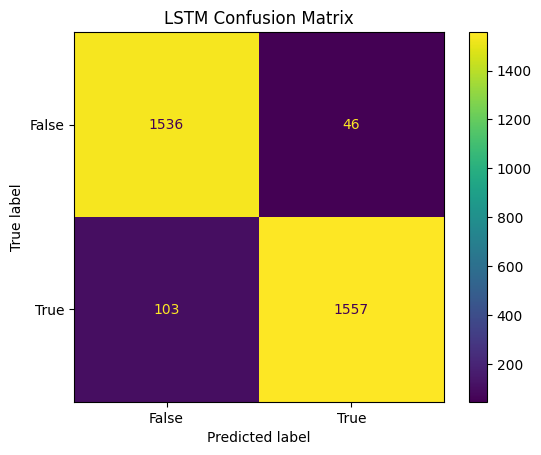

In [42]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(store_labels, store_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


cm_display.plot()
plt.title("LSTM Confusion Matrix")
plt.show()